# Active Learning Comparison with Different Query Strategies
This notebook demonstrates active learning using different query strategies (`UncertaintySampling` and `QueryByCommittee`) on synthetic and real-world datasets.

## Imports

In [31]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import accuracy_score

from skactiveml.pool import UncertaintySampling, QueryByCommittee
from skactiveml.utils import MISSING_LABEL, labeled_indices
from skactiveml.classifier import SklearnClassifier, ParzenWindowClassifier
from skactiveml.visualization import plot_utilities, plot_decision_boundary
from ucimlrepo import fetch_ucirepo

In [45]:
def run_active_learning(X, y_true, clf, qs, n_init=10, n_cycles=20, use_ensemble=False, plot_labeled=True):
    y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
    y[:n_init] = y_true[:n_init]
    accs = []
    feature_bound = [[min(X[:, 0]), min(X[:, 1])], [max(X[:, 0]), max(X[:, 1])]]
    for c in range(n_cycles):
        fig, ax = plt.subplots()

        clf.fit(X, y)
        X_labeled = X[labeled_indices(y)]
        query_idx = qs.query(X=X, y=y, clf=clf) if not use_ensemble else qs.query(X=X, y=y, ensemble=clf)
        acc = accuracy_score(y_true, clf.predict(X))
        accs.append(acc)
        if plot_labeled:
            coll_old = list(ax.collections)
            title = ax.text(
                0.5, 1.05, f"Decision boundary after acquring {c} labels, Acc:{acc}",
                size=plt.rcParams["axes.titlesize"], ha="center",
                transform=ax.transAxes
            )
            if use_ensemble:
                ax = plot_utilities(qs, X=X, y=y, ensemble=clf,
                                candidates=None, res=25,
                                feature_bound=feature_bound, ax=ax)
            else:
                ax = plot_utilities(qs, X=X, y=y, clf=clf,
                                    candidates=None, res=25,
                                    feature_bound=feature_bound, ax=ax)
            ax.scatter(X[:, 0], X[:, 1], c=y_true, cmap="coolwarm", marker=".",
                       zorder=2)
            ax.scatter(X_labeled[:, 0], X_labeled[:, 1], c="grey", alpha=.8,
                       marker=".", s=300)
            ax = plot_decision_boundary(clf, feature_bound, ax=ax)
        y[query_idx] = y_true[query_idx]

    return accs

## Experiment on Synthetic Data

In [37]:
X, y_true = make_blobs(n_samples=200, centers=4, random_state=0)

### Run with Uncertainty Sampling

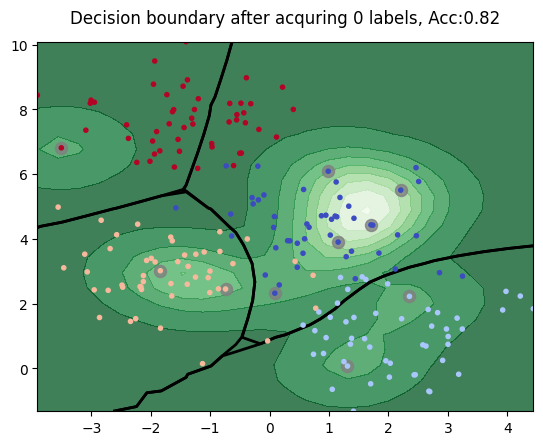

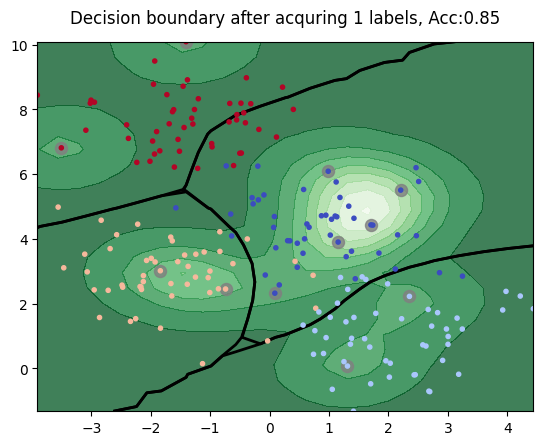

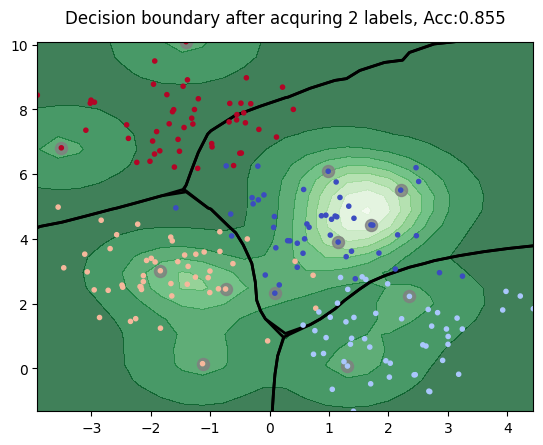

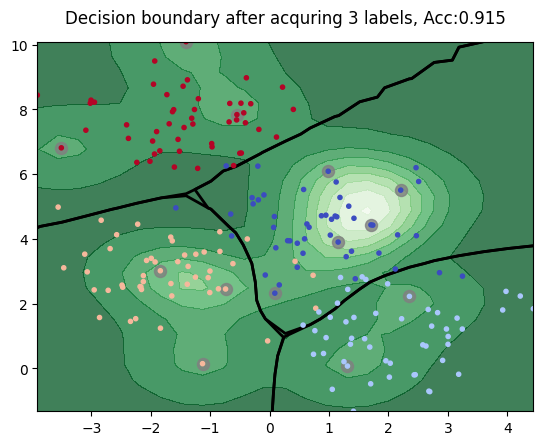

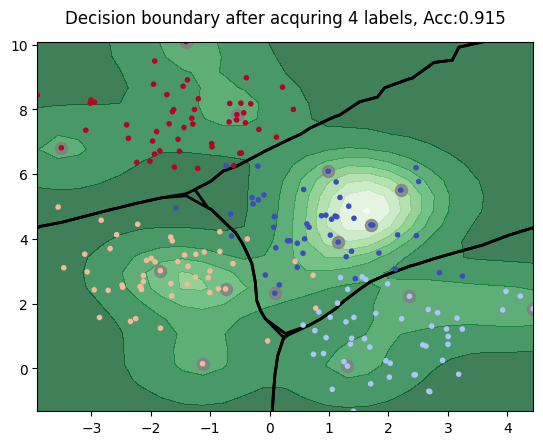

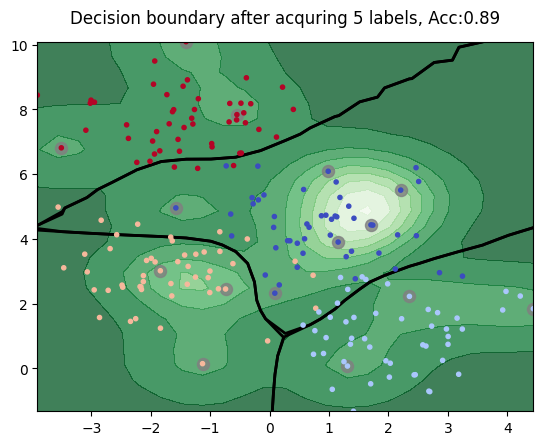

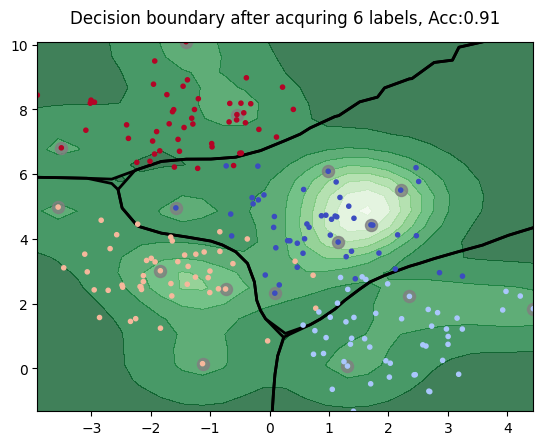

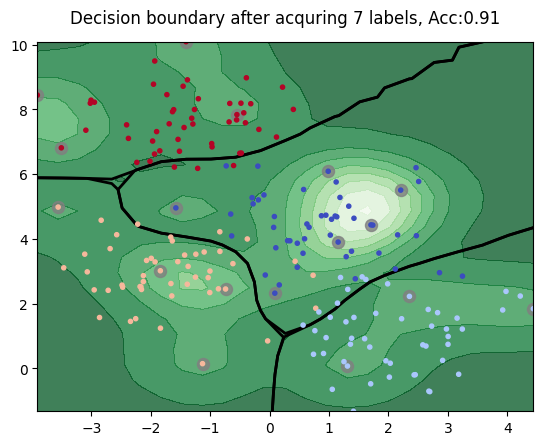

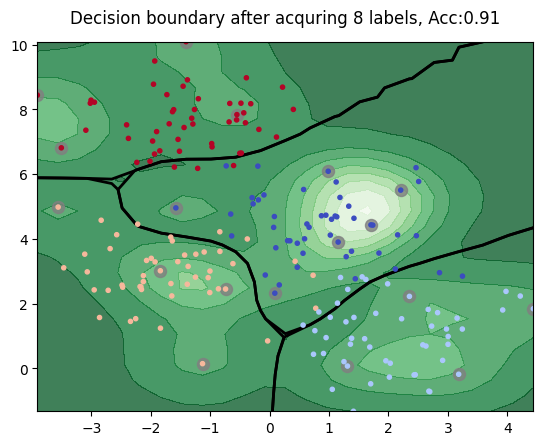

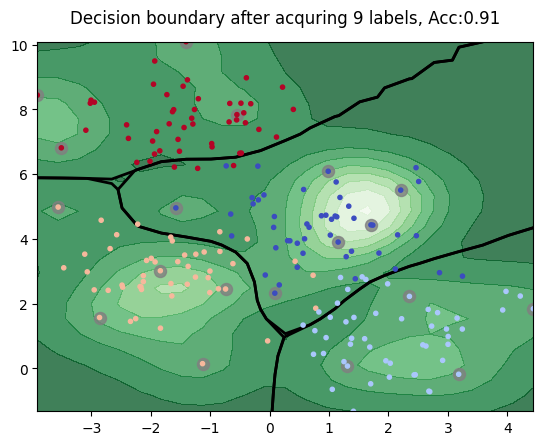

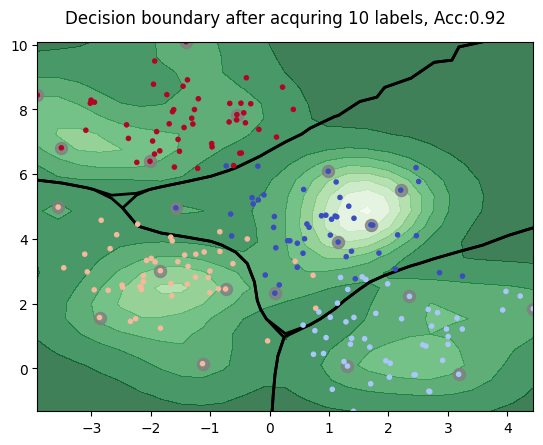

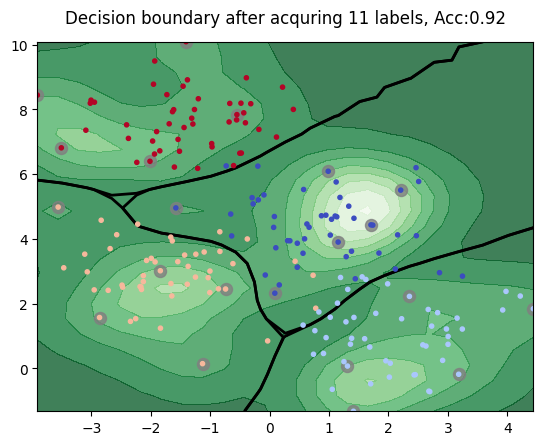

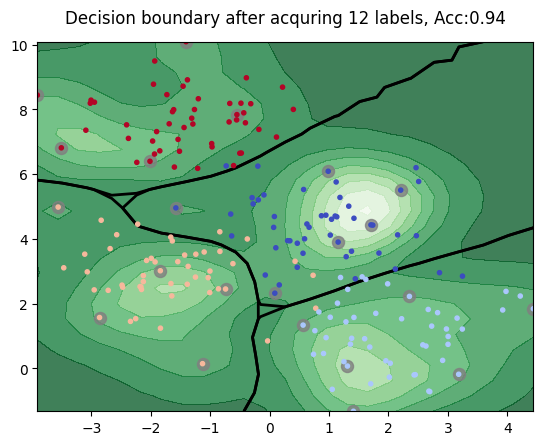

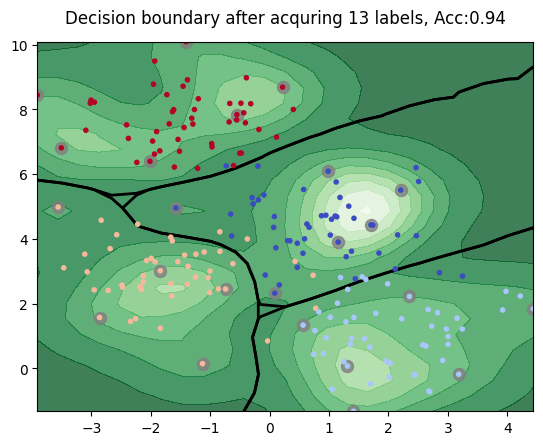

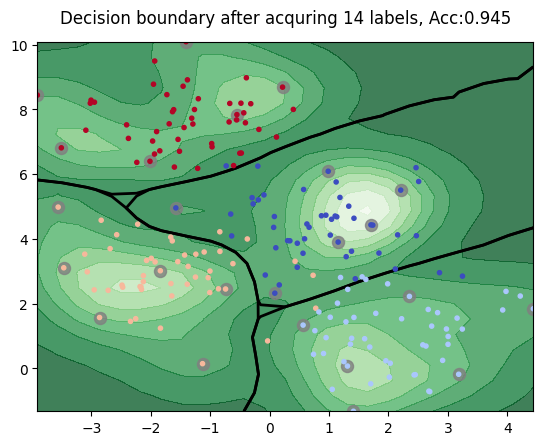

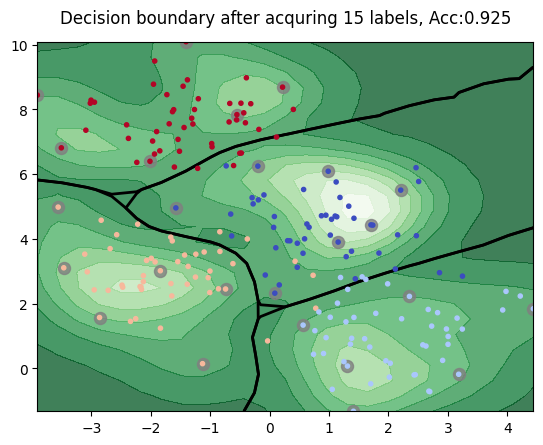

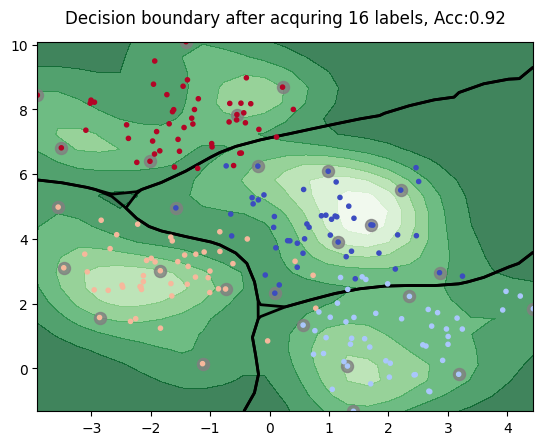

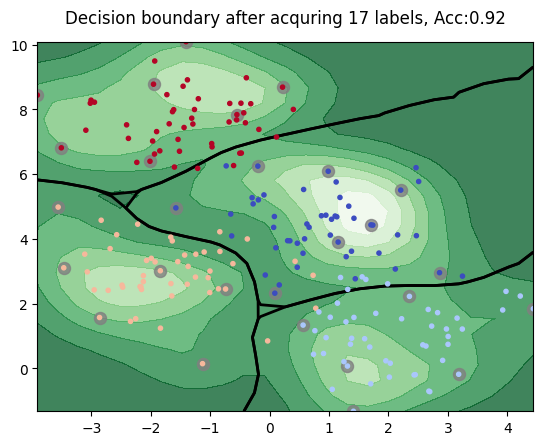

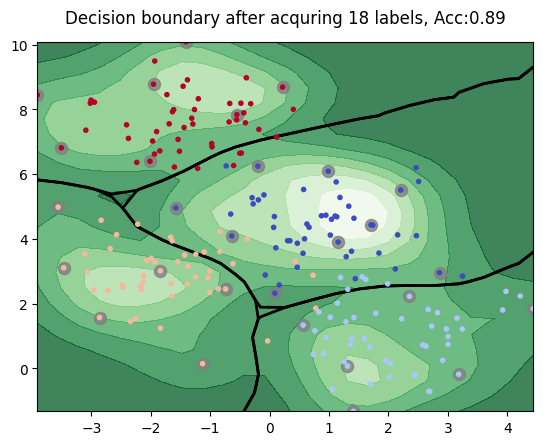

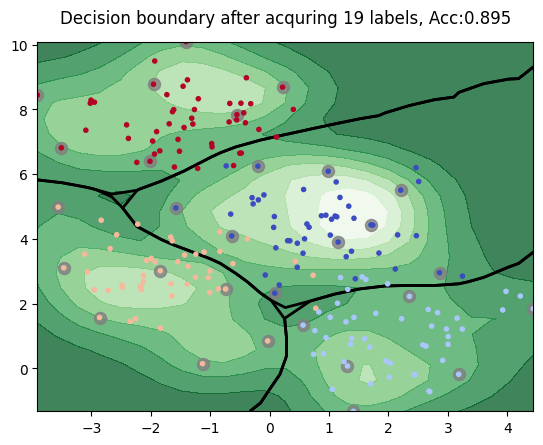

In [38]:
clf_us = SklearnClassifier(GaussianProcessClassifier(random_state=0), classes=np.unique(y_true))
qs_us = UncertaintySampling(method='entropy')
acc_us = run_active_learning(X, y_true, clf_us, qs_us, n_init=10)

### Run with Query by Committee

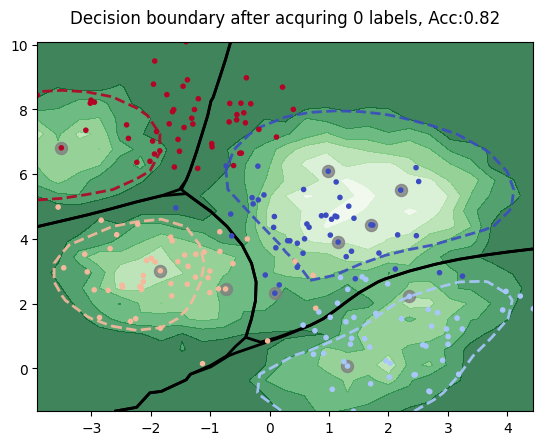

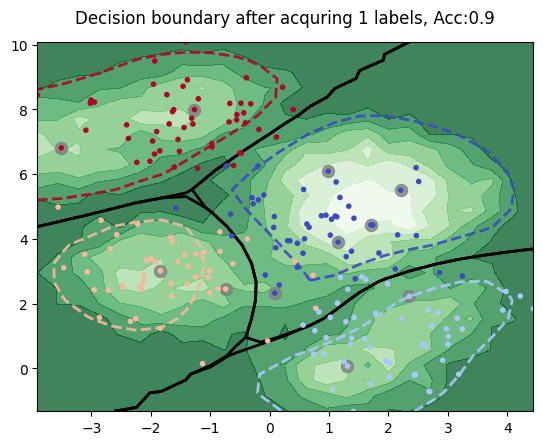

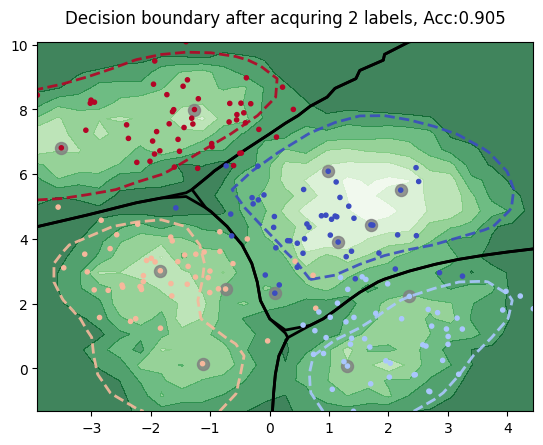

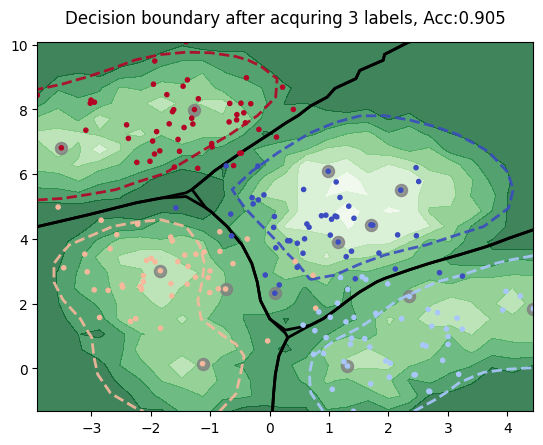

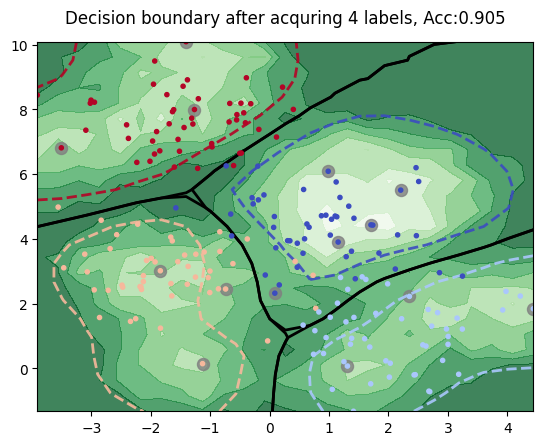

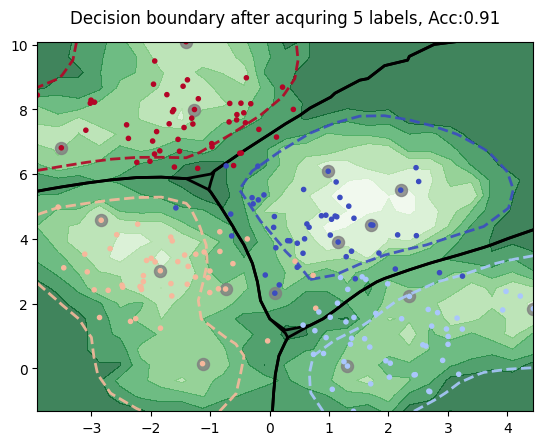

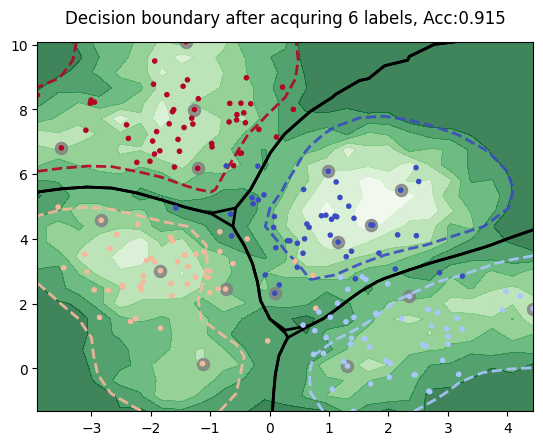

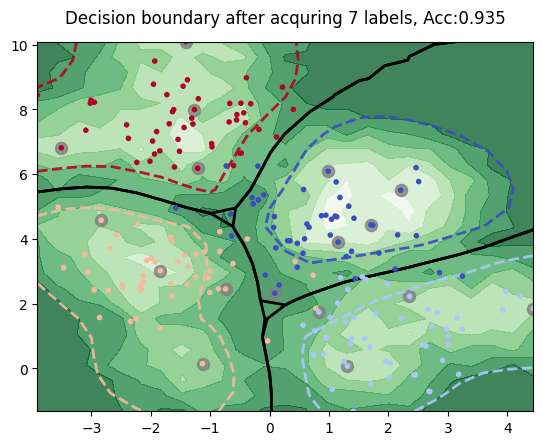

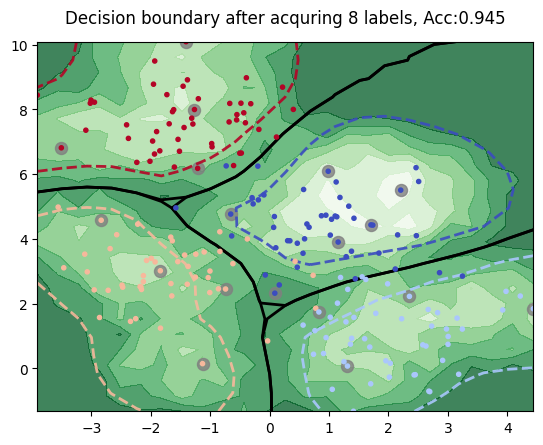

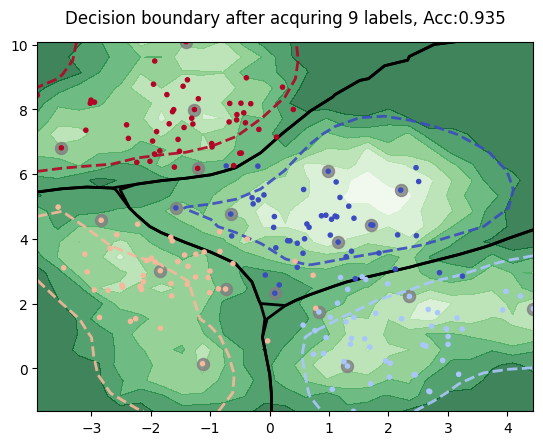

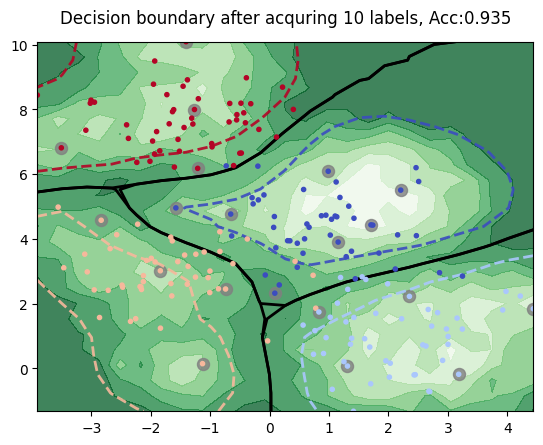

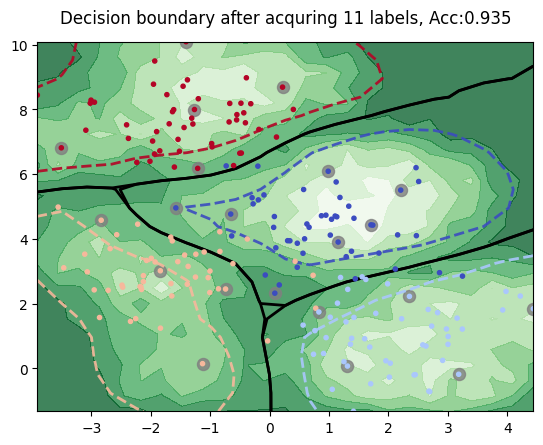

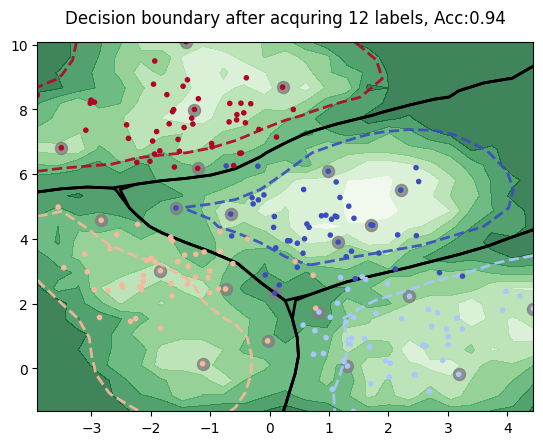

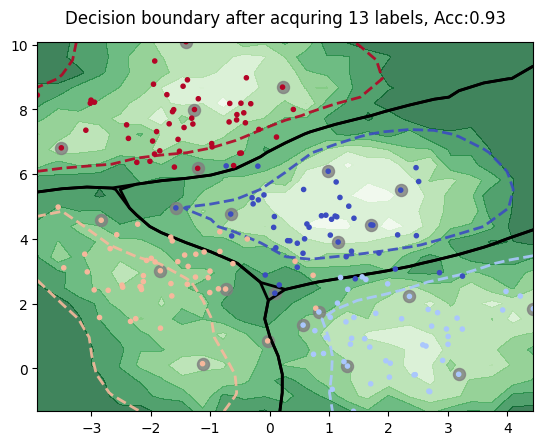

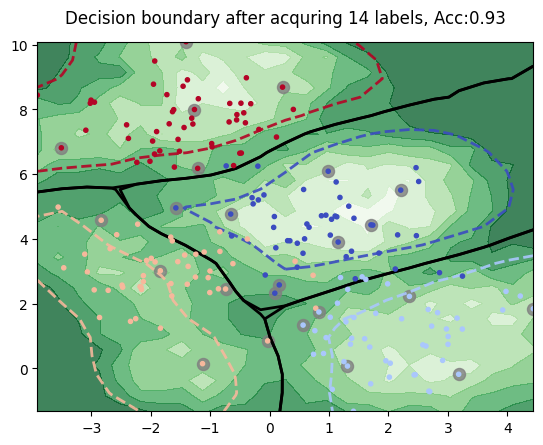

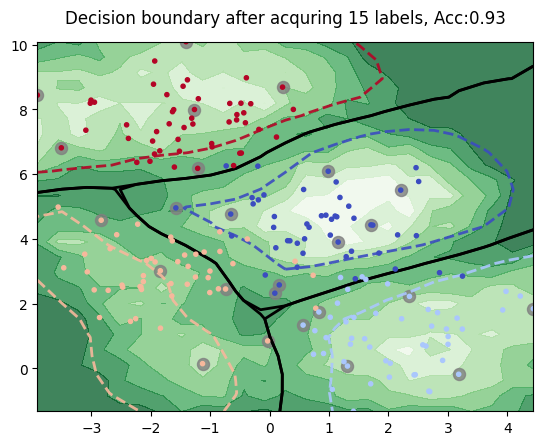

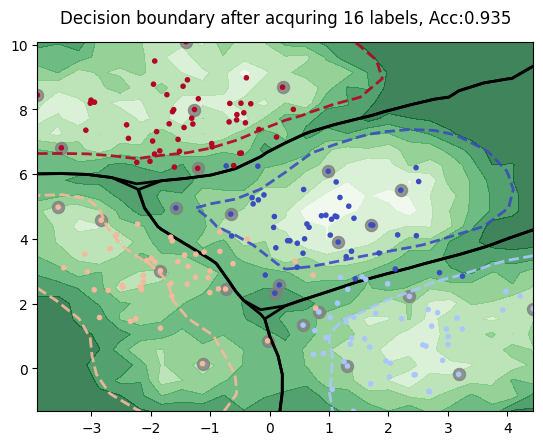

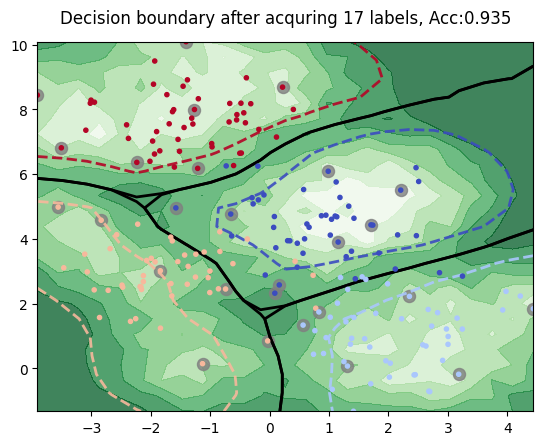

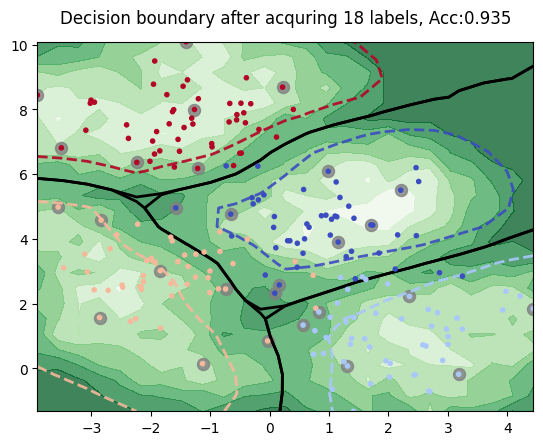

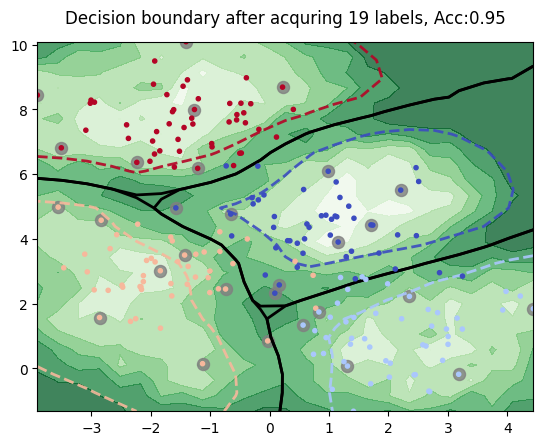

In [39]:
clf_qbc = ParzenWindowClassifier(classes=np.unique(y_true), class_prior=0.1)
qs_qbc = QueryByCommittee(method='vote_entropy', sample_predictions_method_name='sample_proba', sample_predictions_dict={'n_samples': 100})
acc_qbc = run_active_learning(X, y_true, clf_qbc, qs_qbc, n_init=10, use_ensemble=True)

### Accuracy Comparison Plot

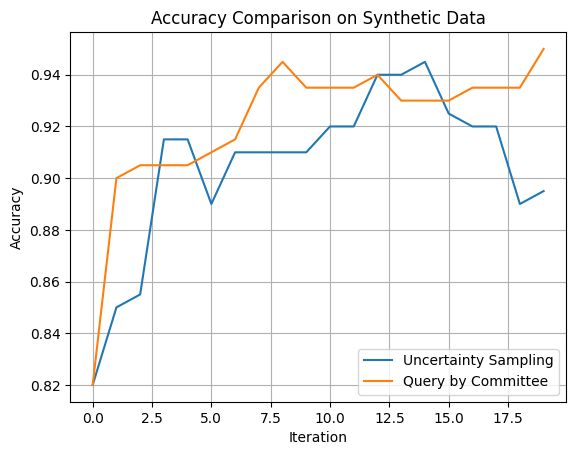

In [40]:
plt.plot(acc_us, label="Uncertainty Sampling")
plt.plot(acc_qbc, label="Query by Committee")
plt.title("Accuracy Comparison on Synthetic Data")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## Experiment on UCI Digits Dataset

In [49]:
optical_recognition_of_handwritten_digits = fetch_ucirepo(id=80)
X = optical_recognition_of_handwritten_digits['data']['features'].to_numpy()
y_true = optical_recognition_of_handwritten_digits['data']['targets'].to_numpy().ravel()

indices = np.arange(len(X))
np.random.shuffle(indices)
X, y_true = X[indices], y_true[indices]


In [51]:
def active_learning_uci(clf, qs, strategy_name, use_ensemble=False):
    y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)

    n = 200
    y[:n] = y_true[:n]
    accs = []
    n_cycles = 20
    for c in range(n_cycles):
        clf.fit(X, y)
        if use_ensemble:
            query_idx = qs.query(X=X, y=y, ensemble=clf)
        else:
            query_idx = qs.query(X=X, y=y, clf=clf)
        acc = accuracy_score(y_true, clf.predict(X))
        accs.append(acc)
        y[query_idx] = y_true[query_idx]

    plt.plot(accs)
    plt.title(f"Accuracy over iterations for {strategy_name}")
    plt.show()

### Run with Uncertainty Sampling

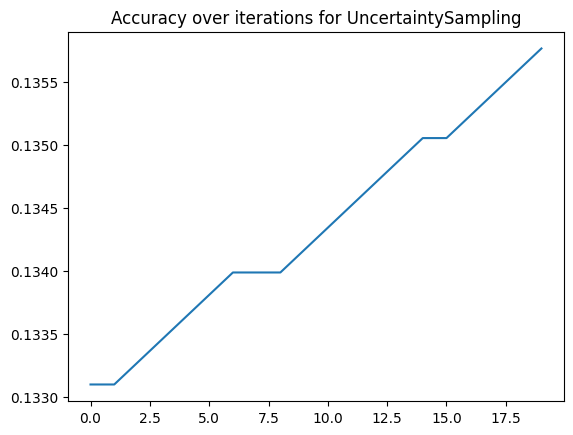

In [53]:
clf_us_d = SklearnClassifier(
    GaussianProcessClassifier(random_state=0),
    classes=np.unique(y_true),
    random_state=0
)
qs_us_d = UncertaintySampling(method='entropy')
acc_us_d = active_learning_uci(clf_us_d, qs_us_d, strategy_name='UncertaintySampling')

### Run with Query by Committee

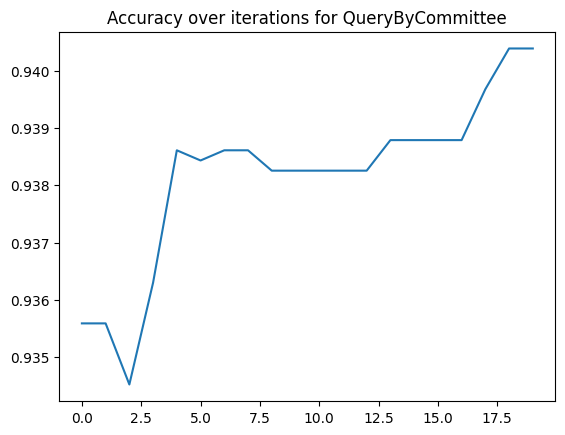

In [55]:
clf_qbc_d = ParzenWindowClassifier(classes=np.unique(y_true), class_prior=0.1)
qs_qbc_d = QueryByCommittee(method='vote_entropy', sample_predictions_method_name='sample_proba', sample_predictions_dict={'n_samples': 100})
acc_qbc_d = active_learning_uci(clf_qbc_d, qs_qbc_d, strategy_name='QueryByCommittee', use_ensemble=True)

We explored two widely used query strategies: Uncertainty Sampling and Query By Committee.

Uncertainty Sampling selects data points for which the model is least confident in its predictions. For example, if a classifier gives nearly equal probability to multiple classes for a particular instance, that instance is considered uncertain and likely to improve the model if labeled.

Query By Committee, on the other hand, uses a group of models (called a committee) that are trained on the current labeled data. It selects instances on which the models in the committee disagree the most. The underlying idea is that disagreement among diverse models indicates uncertainty, and labeling such points is likely to improve model performance.

We applied both strategies to a synthetic dataset and to the UCI Digits dataset. Active learning offers an efficient alternative to traditional supervised learning in label-scarce scenarios. The strategies we tested demonstrate how selectively labeling data can yield strong performance while using fewer resources.